## libs

In [1]:
from __future__ import division, print_function
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *

import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from utils import plots, get_batches, plot_confusion_matrix, get_data

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


## custom functions

In [2]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [3]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

## parameters

In [25]:
#shape dim th patch
#from keras import backend as K
K.set_image_dim_ordering('th')

path = "convbattle2/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

#batch_size=128
batch_size=64

## create custom model

In [26]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

## custom data loading

In [28]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1) #class mode categorical
batches = get_batches(path+'train', shuffle=False, batch_size=1)

val_classes = val_batches.classes
val_labels = onehot(val_batches.classes)
trn_labels = onehot(batches.classes)

filenames = val_batches.filenames

Found 551 images belonging to 2 classes.
Found 2213 images belonging to 2 classes.


In [29]:
batches.class_indices

{'converse': 0, 'newbalance': 1}

In [30]:
trn_data = np.rollaxis(load_array(model_path+'train_data.bc'), 3, 1)
val_data = np.rollaxis(load_array(model_path+'valid_data.bc'), 3, 1)

#val_data = np.rollaxis(get_data(path+'valid'), 3, 1) #get_batches class mode None
#trn_data = np.rollaxis(get_data(path+'train'), 3, 1)

In [31]:
print(trn_labels.shape)
print(val_labels.shape)
print(trn_data.shape)
print(val_data.shape)

(2213, 2)
(551, 2)
(2213, 3, 224, 224)
(551, 3, 224, 224)


## Retrain last layer's linear model

In [32]:
#modify last layer
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))

#modify number of classes = finetuning
classes = list((iter(batches.class_indices)))
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
model.classes = classes

In [33]:
batches.num_class

2

In [34]:
### downgrading batch size
batch_size=64

gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(val_batches.n/batch_size))

print("batch size:" + str(batch_size))
print("calculated steps_per_epoch:" + str(steps_per_epoch) + " | calculated validation_steps:" + str(validation_steps))

batch size:64
calculated steps_per_epoch:35 | calculated validation_steps:9


In [35]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=nb_epoch, 
                        validation_data=val_batches, validation_steps=validation_steps)

##### skipped steps, cause of resuming training

In [17]:
opt = RMSprop(lr=0.003)
#opt = SGD(lr=0.03)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
fit_model(model, batches, val_batches, nb_epoch=2)
model.save_weights(model_path+'finetune.fromscratch2.epoch2.h5')

Epoch 1/2
18/18 [==============================] - 49s - loss: 9.4490 - acc: 0.4138 - val_loss: 9.2730 - val_acc: 0.4247
Epoch 2/2
18/18 [==============================] - 49s - loss: 9.1782 - acc: 0.4306 - val_loss: 9.2730 - val_acc: 0.4247


In [20]:
model.load_weights(model_path+'finetune.fromscratch.epoch8.h5')

In [21]:
fit_model(model, batches, val_batches, nb_epoch=2)
model.save_weights(model_path+'finetune.fromscratch.epoch10.h5')

Epoch 1/2
18/18 [==============================] - 49s - loss: 2.1457 - acc: 0.7554 - val_loss: 0.7772 - val_acc: 0.8603
Epoch 2/2
18/18 [==============================] - 49s - loss: 1.0965 - acc: 0.8163 - val_loss: 0.7177 - val_acc: 0.8530


##### end of skipped steps

In [39]:
opt = RMSprop(lr=0.000003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.load_weights(model_path+'finetune.fromscratch.epoch12.h5')

In [43]:
fit_model(model, batches, val_batches, nb_epoch=1)
model.save_weights(model_path+'finetune.fromscratch.epoch13.h5')

Epoch 1/1
35/35 [==============================] - 51s - loss: 0.5783 - acc: 0.8759 - val_loss: 0.6825 - val_acc: 0.8548


## run prediction

In [17]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

551/551 [==============================] - 10s    


array([  1.0000e+00,   9.9959e-01,   9.9993e-01,   9.9999e-01,   1.8955e-01,   1.0000e+00,
         2.8568e-06,   1.0000e+00], dtype=float32)

[[190  44]
 [ 36 281]]


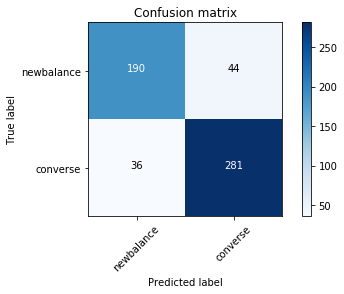

In [18]:
#cm = confusion_matrix(val_classes, preds)
val_classes = list((iter(val_classes)))
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'converse':0, 'newbalance':1})

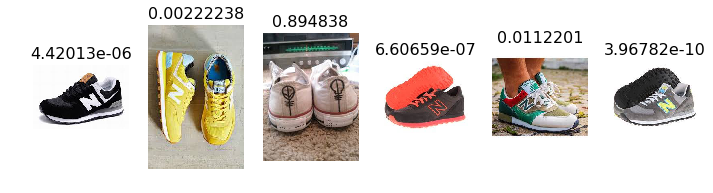

In [19]:
#print(filenames)
n_view = 6

#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

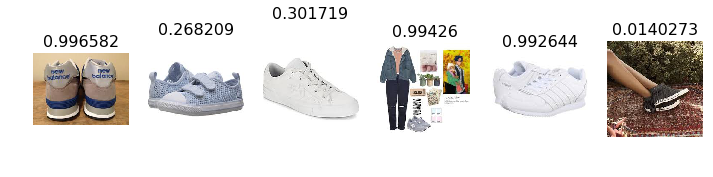

In [20]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

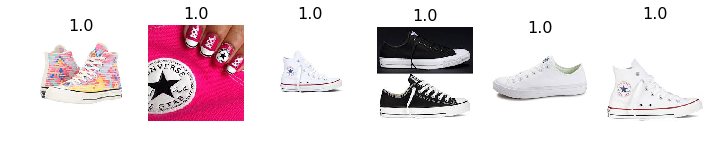

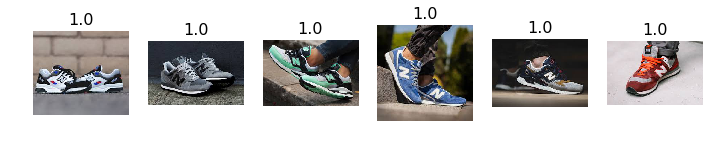

In [21]:
#3. The images we most confident were CONVERSE, and are actually CONVERSE
correct_converse = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_converse = np.argsort(probs[correct_converse])[::-1][:n_view]
plots_idx(correct_converse[most_correct_converse], probs[correct_converse][most_correct_converse])

# as above, but NEW BALANCE
correct_newb = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_newb = np.argsort(probs[correct_newb])[:n_view]
plots_idx(correct_newb[most_correct_newb], 1-probs[correct_newb][most_correct_newb])

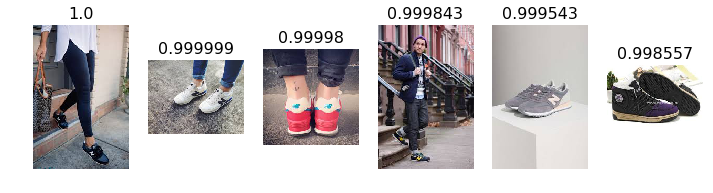

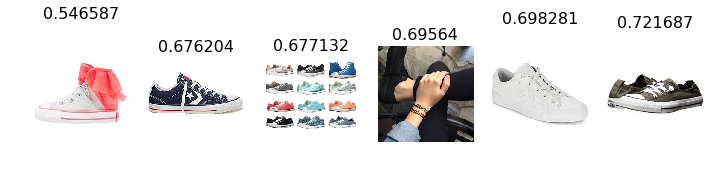

In [22]:
#4. The images we were most confident were CONVERSE, but are actually NEWBALANCE
incorrect_converse = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_converse = np.argsort(probs[incorrect_converse])[::-1][:n_view]
plots_idx(incorrect_converse[most_incorrect_converse], probs[incorrect_converse][most_incorrect_converse])

# as above, but NEW BALANCE
incorrect_newb = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_newb = np.argsort(probs[incorrect_newb])[::-1][:n_view]
plots_idx(incorrect_newb[most_incorrect_newb], 1-probs[incorrect_newb][most_incorrect_newb])

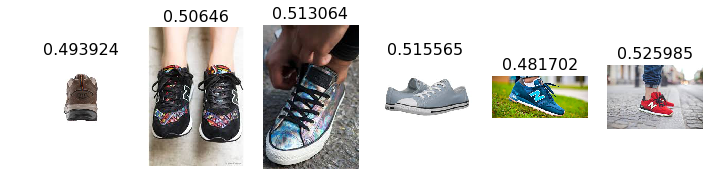

In [23]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

## Retraining Dense Layers

In [49]:
model.load_weights(model_path+'finetune.fromscratch.epoch13.h5')

In [50]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

print("first dense layer id : " + str(first_dense_idx))

first dense layer id : 33


In [51]:
#K.set_value(opt.lr, 0.003)
opt = RMSprop(lr=0.00003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

fit_model(model, batches, val_batches, 1)
model.save_weights(model_path+'finetune.fromscratch.DenseLayers2.epoch01.h5')

Epoch 1/1
35/35 [==============================] - 55s - loss: 0.7711 - acc: 0.8808 - val_loss: 0.5059 - val_acc: 0.8711


## Retraining More Layers

In [59]:
model.load_weights(model_path+'finetune.fromscratch.DenseLayers2.epoch01.h5')

In [60]:
# 12+ layers = 3 last CNN blocks (out of 5) + FC layers
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.000003)

In [61]:
fit_model(model, batches, val_batches, 1)

Epoch 1/1
35/35 [==============================] - 55s - loss: 0.1929 - acc: 0.9441 - val_loss: 0.5056 - val_acc: 0.8766


In [62]:
model.save_weights(model_path+'finetune.fromscratch.AllLayers.epoch01.h5')

## run prediction

In [63]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

551/551 [==============================] - 10s    


array([  1.0000e+00,   9.9477e-01,   9.9999e-01,   9.9999e-01,   2.7881e-01,   1.0000e+00,
         1.2390e-04,   1.0000e+00], dtype=float32)

[[192  42]
 [ 26 291]]


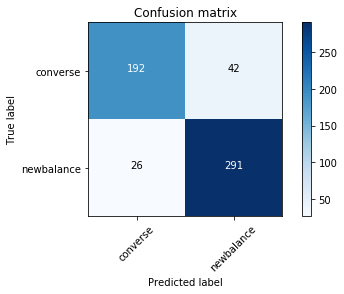

In [64]:
#cm = confusion_matrix(val_classes, preds)
val_classes = list((iter(val_classes)))
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'converse':0, 'newbalance':1})